<a href="https://colab.research.google.com/github/chomamat/fit-bp/blob/master/src/13_niklaus_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!cp gdrive/My\ Drive/x64/*.npy .
!cp gdrive/My\ Drive/*.py .
!ls -l

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
total 949916
-rw------- 1 root root      2875 Apr  3 20:39 _dataset_tools.py
drwx------ 3 root root      4096 Apr  3 20:39 gdrive
-rw------- 1 root root      2625 Apr  3 20:39 _my_tools.py
drwxr-xr-x 1 root root      4096 Mar 27 20:26 sample_data
-rw------- 1 root root      4159 Apr  3 20:40 _torch_tools.py
-rw------- 1 root root       932 Apr  3 20:40 _video_tools.py
-rw------- 1 root root 129687680 Apr  3 20:39 X_test.npy
-rw------- 1 root root 518750336 Ap

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import _torch_tools as tt
import _my_tools as mt
import numpy as np
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device is", device)
X_train, y_train, X_test, y_test = mt.loadData("",'float16',channels_last=False)

Device is cuda:0


In [0]:
FILTER_SIZE = 25
NUM_WORKERS = 10

# taken from Kartasev et al.
class SeparableConvolutionSlow(nn.Module):
    def __init__(self):
        super(SeparableConvolutionSlow, self).__init__()
    
    def forward(self, im, vertical, horizontal):
        n_b = im.size(0)
        n_channels = im.size(1)
        m = im.size(2)
        m_out = m - FILTER_SIZE + 1
        
        assert im.size(2) == im.size(3)
        assert vertical.size(0) == horizontal.size(0) == n_b
        assert vertical.size(1) == horizontal.size(1) == FILTER_SIZE
        assert vertical.size(2) == horizontal.size(2) == vertical.size(3) == horizontal.size(3) == m_out

#         print("vertical -",vertical.shape)
#         print("horizontal -", horizontal.shape)
        
        n_workers = NUM_WORKERS

        if os.name == 'nt' and NUM_WORKERS > 1:
#             print('Parallel Separable Convolution on CPU not supported on Windows. Proceeding on main thread...')
            n_workers = 1

        if vertical.requires_grad and NUM_WORKERS > 1:
#             print('Parallel Separable Convolution on CPU not supported during training. Proceeding on main thread...')
            n_workers = 1

        output = im.new().resize_(n_b, n_channels, m_out, m_out).zero_()

        if n_workers > 1:
            return parallel_sep_conv(im, horizontal, vertical, output, n_workers)
        else:
            return sep_conv(im, horizontal, vertical, output)


def local_separable_conv_2d(im, horizontal, vertical, output=None):
    """im: [n_channels x m x m], horizontal: [51 x m x m], vertical: [51 x m x m]
       -> return: [n_channels x (m - 50) x (m - 50)]"""
    n_b = im.size(0)
    n_channels = im.size(1)
    m = im.size(2)
    m_out = m - FILTER_SIZE + 1
    if output is None:
        output = t.zeros((n_channels, m_out, m_out))
    for row in range(m_out):
        for col in range(m_out):
            sub_patch = im[:,:, row:row + FILTER_SIZE, col:col + FILTER_SIZE]
            local_horiz = horizontal[:,:, row, col].view(n_b, 1, 1,- 1)
            local_vert = vertical[:,:, row, col].view(n_b, 1, -1, 1)
#             print(sub_patch.shape)
#             print(local_horiz.shape)
#             print(local_vert.shape, " - default -", vertical.shape)
            output[:, :, row, col] = (sub_patch * local_horiz * local_vert).sum(dim=2).sum(dim=2)
    return output


def _sep_conv_worker(im, horizontal, vertical, output, worker_batch_size, offset):
#     n_b = im.size(0)
#     max_range = min(n_b, worker_batch_size+offset)
#     for b in range(offset, max_range):
#         local_separable_conv_2d(im[b], horizontal[b], vertical[b], output=output[b])

    local_separable_conv_2d(im, horizontal, vertical, output=output)
    return output


def sep_conv(im, horizontal, vertical, output):
    """
    Runs the separable convolution on multiple images sequentially on a single thread
    :param im: Input images as a tensor. im[0] must correspond to the first image of the batch
    :param horizontal: Set of horizontal filters as a tensor
    :param vertical: Set of vertical filters as a tensor
    :param output: Tensor used as output. Same shape as im. Must be passed pre-allocated and initialized with zeros
    :return: Tensor resulting from the convolution
    """
    return _sep_conv_worker(im, horizontal, vertical, output, im.size(0), 0)


def parallel_sep_conv(im, horizontal, vertical, output, n_workers):
    """
    Spawns the specified amount of workers to run the separable convolution on multiple images in parallel
    :param im: Input images as a tensor. im[0] must correspond to the first image of the batch
    :param horizontal: Set of horizontal filters as a tensor
    :param vertical: Set of vertical filters as a tensor
    :param output: Tensor used as output. Same shape as im. Must be passed pre-allocated and initialized with zeros
    :param n_workers: Number of workers to be used. Must be greater than zero
    :return: Tensor resulting from the convolution
    """

    n_b = im.size(0)
    n_workers = min(n_b, n_workers)
    worker_batch_size = n_b // n_workers
    processes = []

    output.share_memory_()

    for i in range(n_workers):

        offset = worker_batch_size * i
        if i == n_workers-1:
            worker_batch_size += n_b % n_workers

        p = mp.Process(target=_sep_conv_worker, args=(im, horizontal, vertical, output, worker_batch_size, offset,))
        p.start()
        processes.append(p)

    for p in processes:
        p.join()

    return output

In [0]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.KERNEL_SIZE = 25
        self.activation = nn.PReLU()
        
        self.conv_setup = {
            'kernel' : (3,3),
            'stride' : (1,1),
            'padding' : 1,
            'activation' : self.activation
        }
        self.pooling_setup = {
            'kernel_size' : (2,2),
            'stride' : (2,2)
        }
        self.upsample_setup = {
            'scale_factor' : 2,
            'mode' : 'bilinear',
            'align_corners' : True
        }

        self.pooling_layer = nn.AvgPool2d(**self.pooling_setup)
        self.upsample_layer = nn.Upsample(**self.upsample_setup)
        self.pad = nn.ReplicationPad2d(self.KERNEL_SIZE // 2)
        
        self.conv32 = self._convBlock(2, 32, **self.conv_setup)
        self.conv64 = self._convBlock(32, 64, **self.conv_setup)
        self.conv128 = self._convBlock(64, 128, **self.conv_setup)
        self.conv256 = self._convBlock(128, 256, **self.conv_setup)
        
        self.conv256_256 = self._convBlock(256, 256, **self.conv_setup)

        self.upsample256 = self._upsampleBlock(self.upsample_layer, 256, 256, **self.conv_setup)
        self.deconv128 = self._convBlock(256, 128, **self.conv_setup)
        self.upsample128 = self._upsampleBlock(self.upsample_layer, 128, 128, **self.conv_setup)
        self.deconv64 = self._convBlock(128, 64, **self.conv_setup)
        self.upsample64 = self._upsampleBlock(self.upsample_layer, 64, 64, **self.conv_setup)
        
        self.kernel_1h = self._kernelBlock(self.upsample_layer, 64, self.KERNEL_SIZE, **self.conv_setup)
        self.kernel_1v = self._kernelBlock(self.upsample_layer, 64, self.KERNEL_SIZE, **self.conv_setup)
        self.kernel_2h = self._kernelBlock(self.upsample_layer, 64, self.KERNEL_SIZE, **self.conv_setup)
        self.kernel_2v = self._kernelBlock(self.upsample_layer, 64, self.KERNEL_SIZE, **self.conv_setup)
        
        self.separable_conv = SeparableConvolutionSlow()
        
    def forward(self, x):
        img1 = x[:,:1,:,:]
        img2 = x[:,1:,:,:]
        
        # compression
        
        x32 = self.conv32(x)
        x32_p = self.pooling_layer(x32)
        x64 = self.conv64(x32_p)
        x64_p = self.pooling_layer(x64)
        x128 = self.conv128(x64_p)
        x128_p = self.pooling_layer(x128)
        x256 = self.conv256(x128_p)
        x256_p = self.pooling_layer(x256)

        x = self.conv256_256(x256_p)

        # expansion

        x = self.upsample256(x)
        x += x256
        x = self.deconv128(x)

        x = self.upsample128(x)
        x += x128
        x = self.deconv64(x)

        x = self.upsample64(x)
        x += x64
        
        # creating kernels & image padding
        
        k_1h = self.kernel_1h(x)
        k_1v = self.kernel_1v(x)
        k_2h = self.kernel_2h(x)
        k_2v = self.kernel_2v(x)
        
        p_img1 = self.pad(img1)
        p_img2 = self.pad(img2)
                
        return self.separable_conv(p_img1, k_1v, k_1h) + self.separable_conv(p_img2, k_2v, k_2h)
    
    @staticmethod
    def _convBlock(in_channels, out_channels, kernel, stride, padding, activation):
        return nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel, stride, padding), activation,
            nn.Conv2d(in_channels, in_channels, kernel, stride, padding), activation,
            nn.Conv2d(in_channels, out_channels, kernel, stride, padding), activation
        )
    @staticmethod
    def _kernelBlock(upsample, in_channels, out_channels, kernel, stride, padding, activation):
        return nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel, stride, padding), activation,
            nn.Conv2d(in_channels, in_channels, kernel, stride, padding), activation,
            nn.Conv2d(in_channels, out_channels, kernel, stride, padding), activation,
            upsample,
            nn.Conv2d(out_channels, out_channels, kernel, stride, padding)
        )
    @staticmethod
    def _upsampleBlock(upsample, in_channels, out_channels, kernel, stride, padding, activation):
        return nn.Sequential(
            upsample,
            nn.Conv2d(in_channels, out_channels, kernel, stride, padding), activation
        )

In [25]:
model = Model()
training = tt.Training(model, device, X_train, y_train, X_test, y_test)
training.fit(16, 1, val=False
            )

====== HYPERPARAMETERS ======
batch_size : 16
epochs : 1
loss function : L1Loss()
optimizer : Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.002
    weight_decay: 0
)
device : cuda:0
===> Epoch[0]

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


===> Epoch[0](3957/3957): Loss: 0.0220	ETA 0:00:18	Epoch Loss: 0.0348
Epoch[0] finished in 10:20:53 with loss 0.03482173419151985

----------------------------

Finished training of 1 epochs in 10:20:54.


{'train': [0.03482173419151985], 'val': []}

In [0]:
training.fit(64, 1, val=False)

====== HYPERPARAMETERS ======
batch_size : 64
epochs : 1
loss function : L1Loss()
optimizer : Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.002
    weight_decay: 0
)
device : cuda:0
===> Epoch[0]

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


===> Epoch[0](55/989): Loss: 0.0297	ETA 7:25:02	Epoch Loss: 0.0282

In [0]:
torch.save(model.state_dict(), "weights")
!cp weights gdrive/My\ Drive/.

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


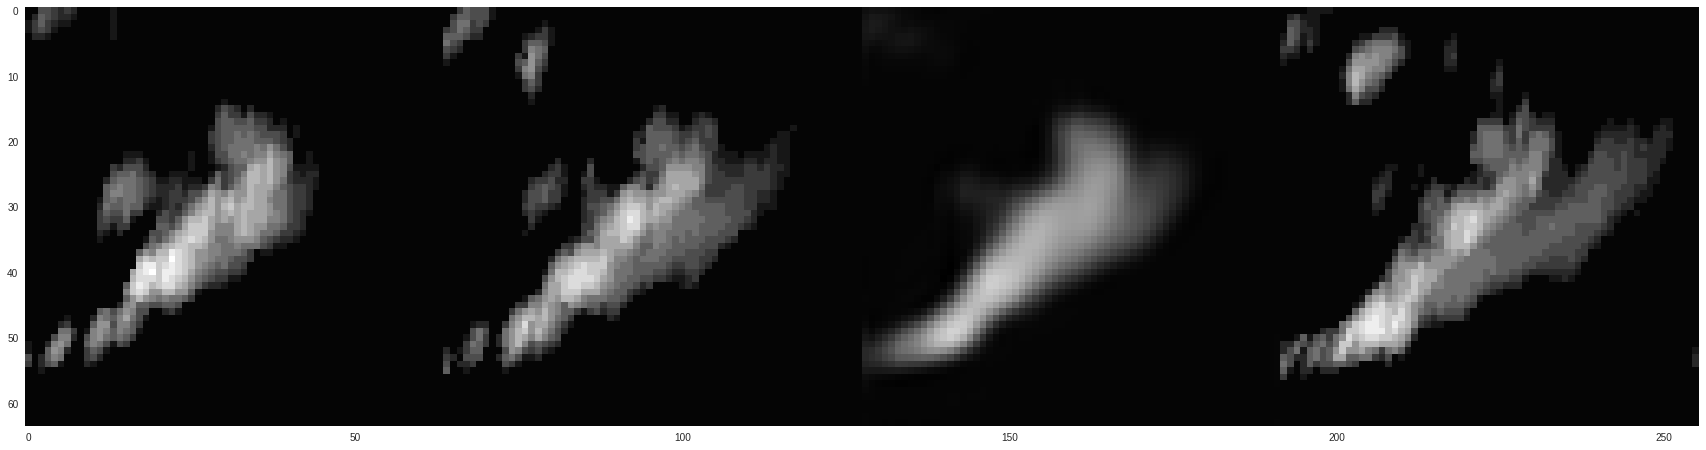

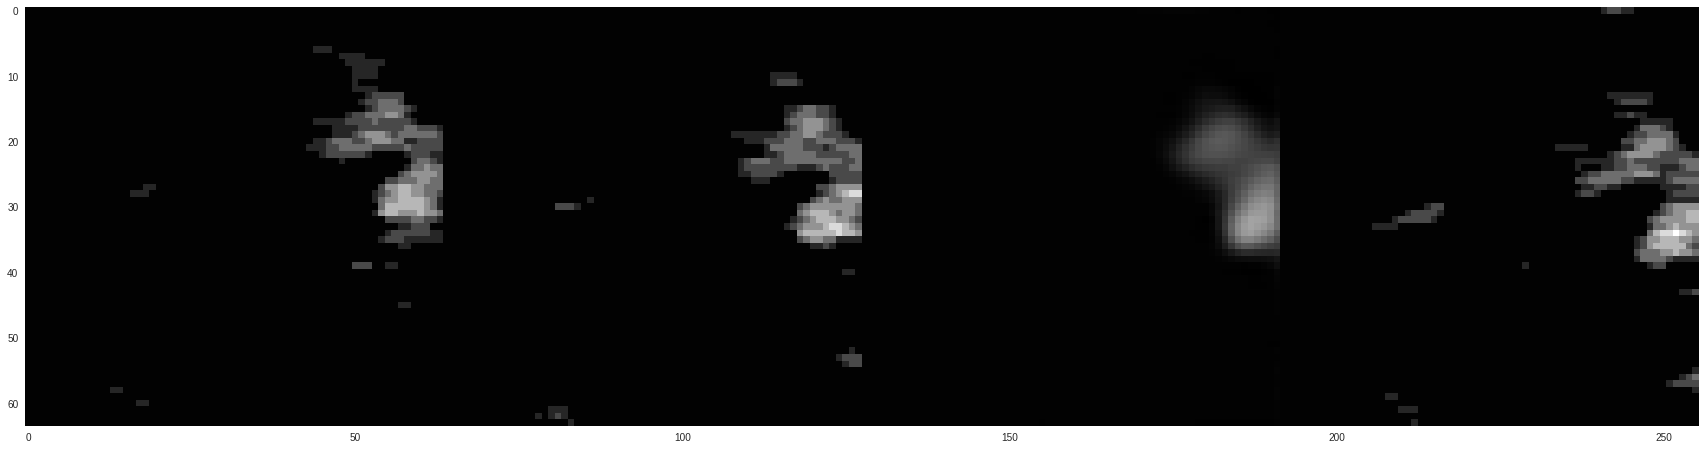

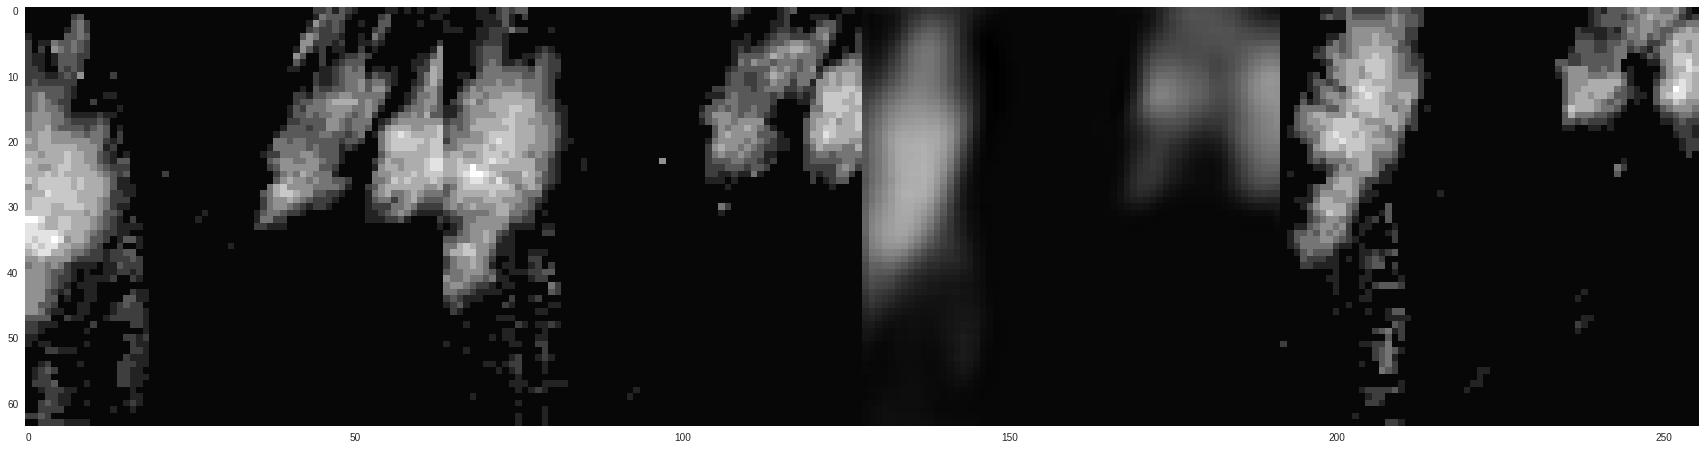

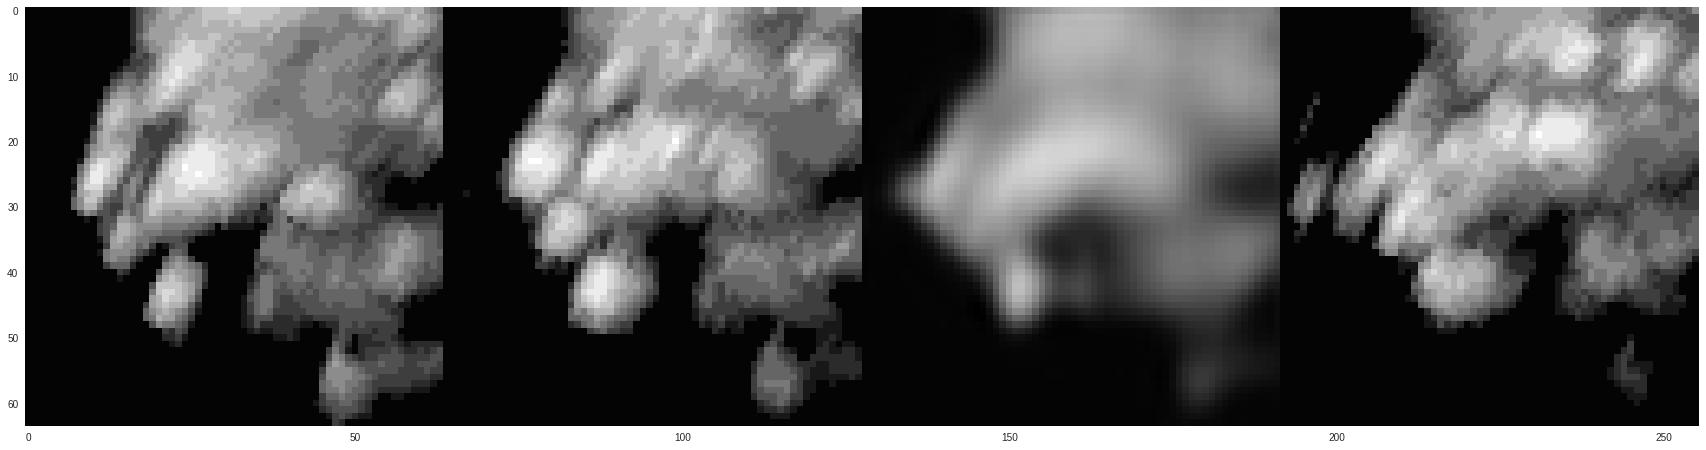

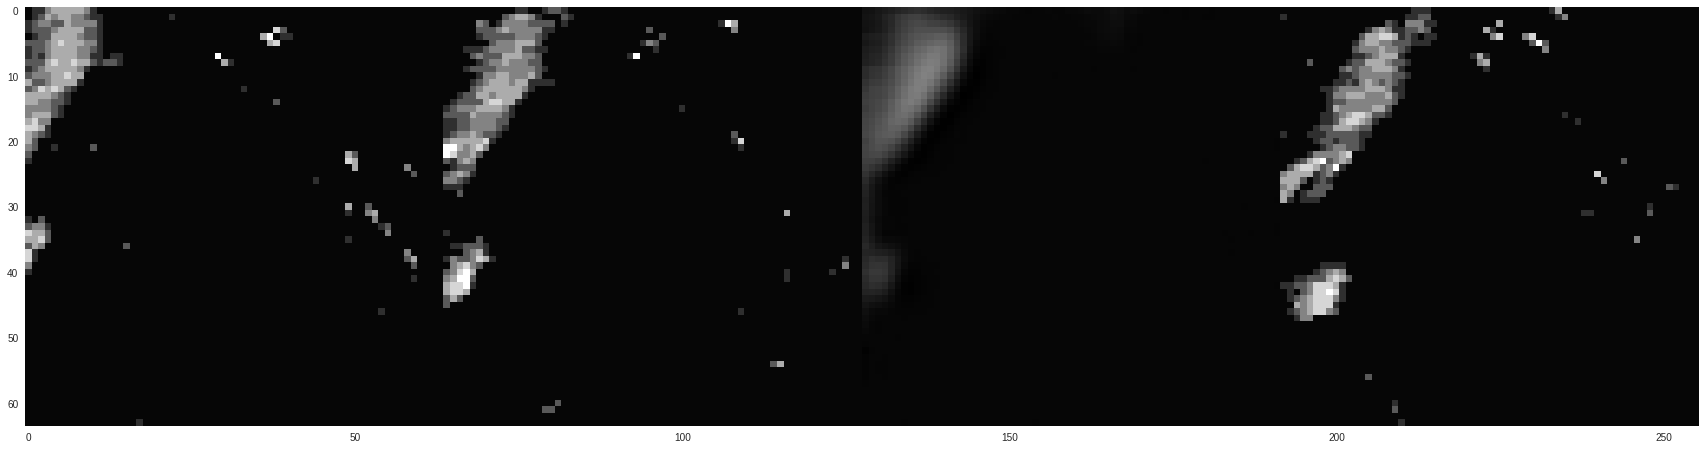

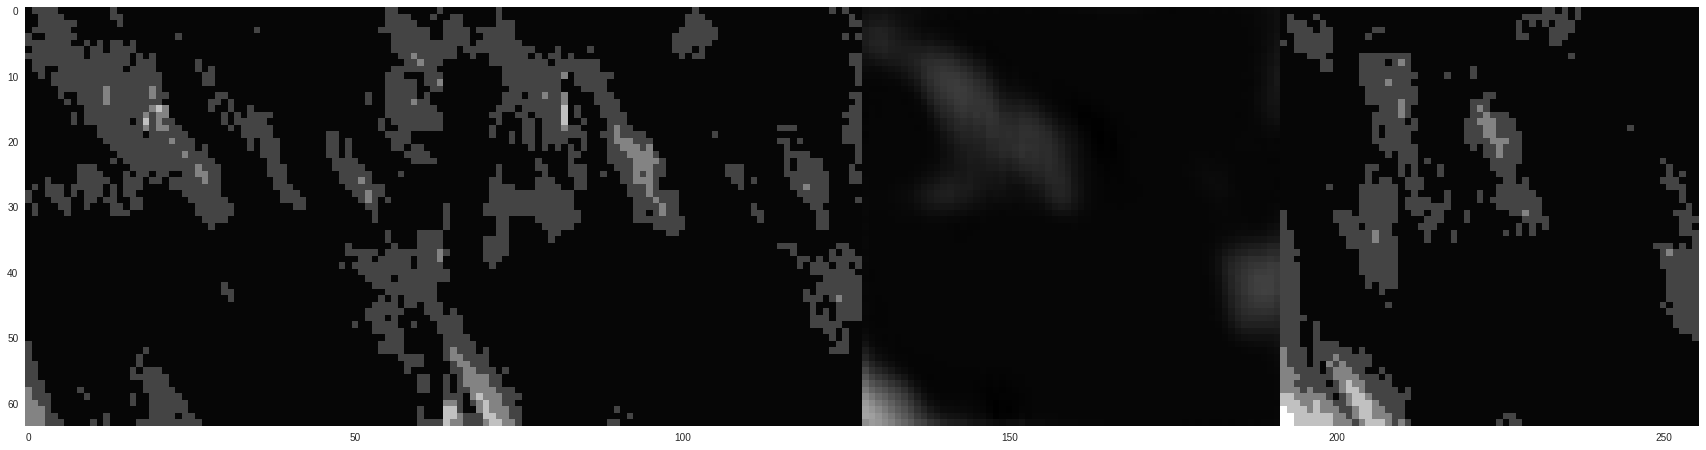

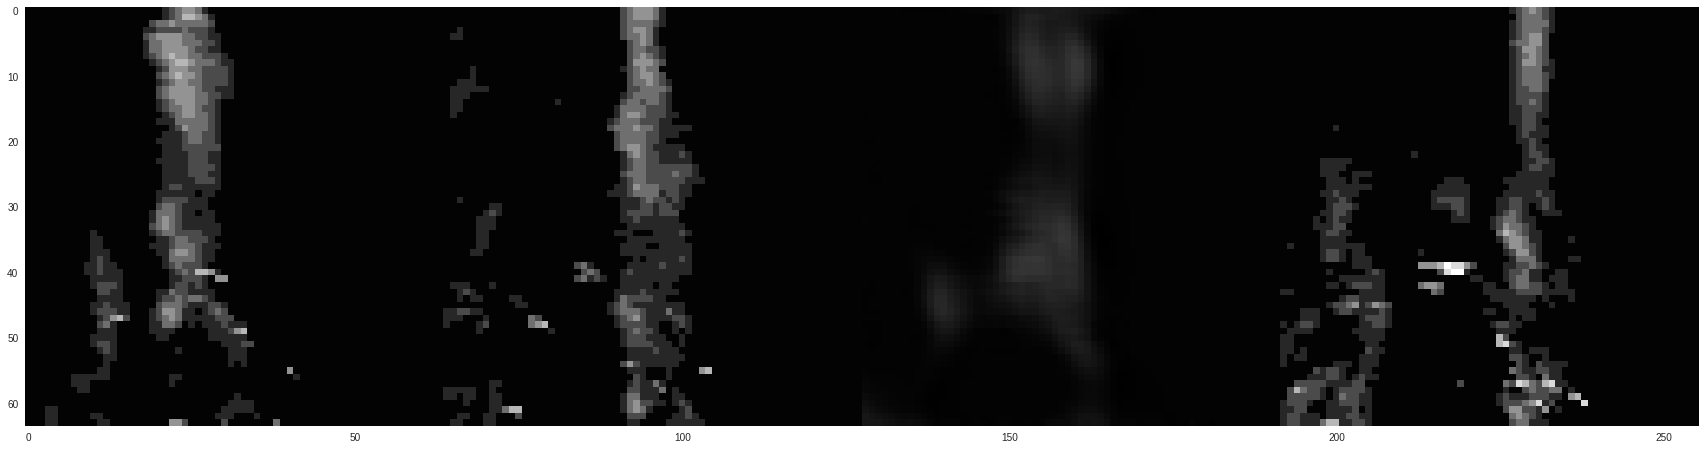

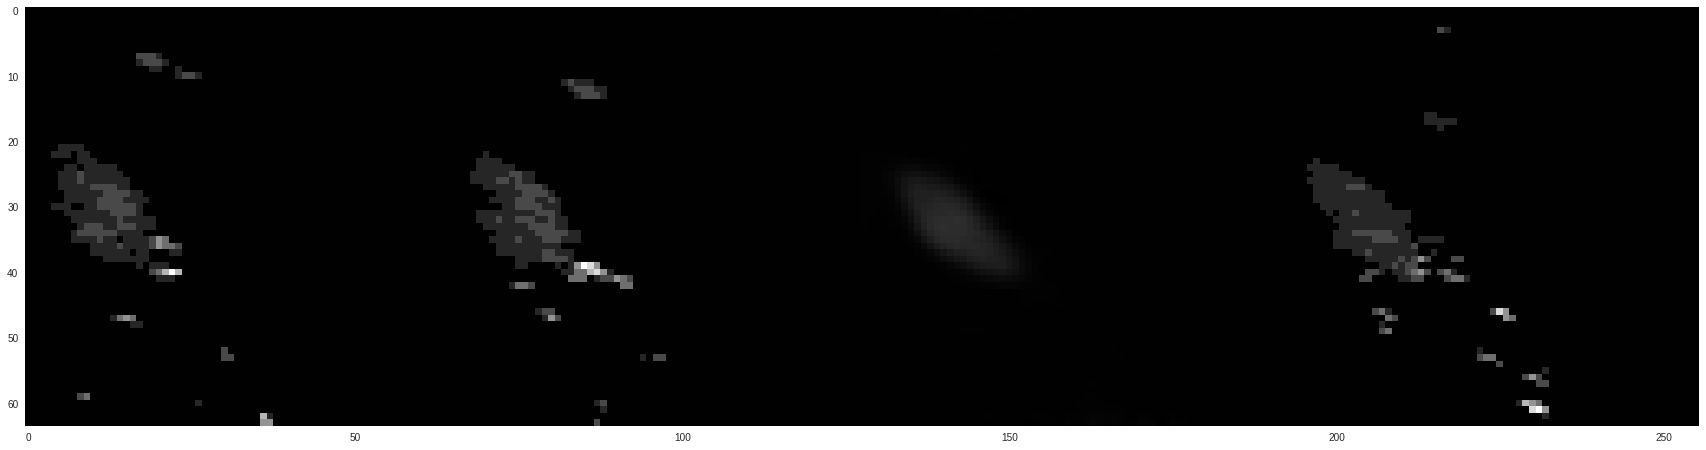

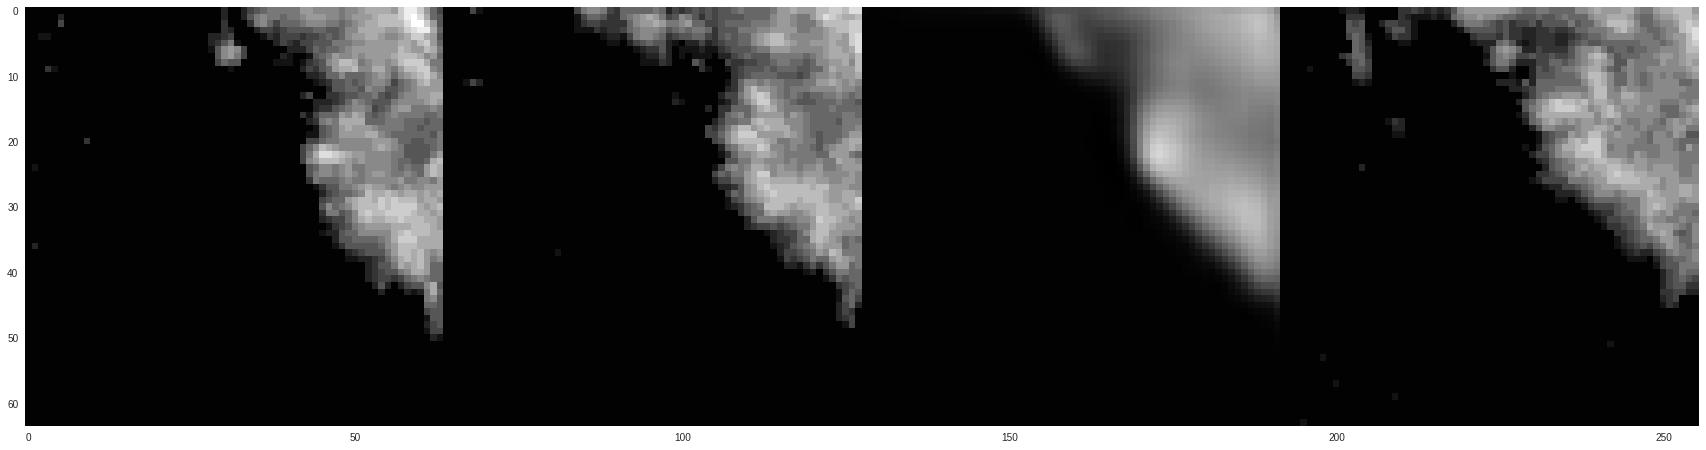

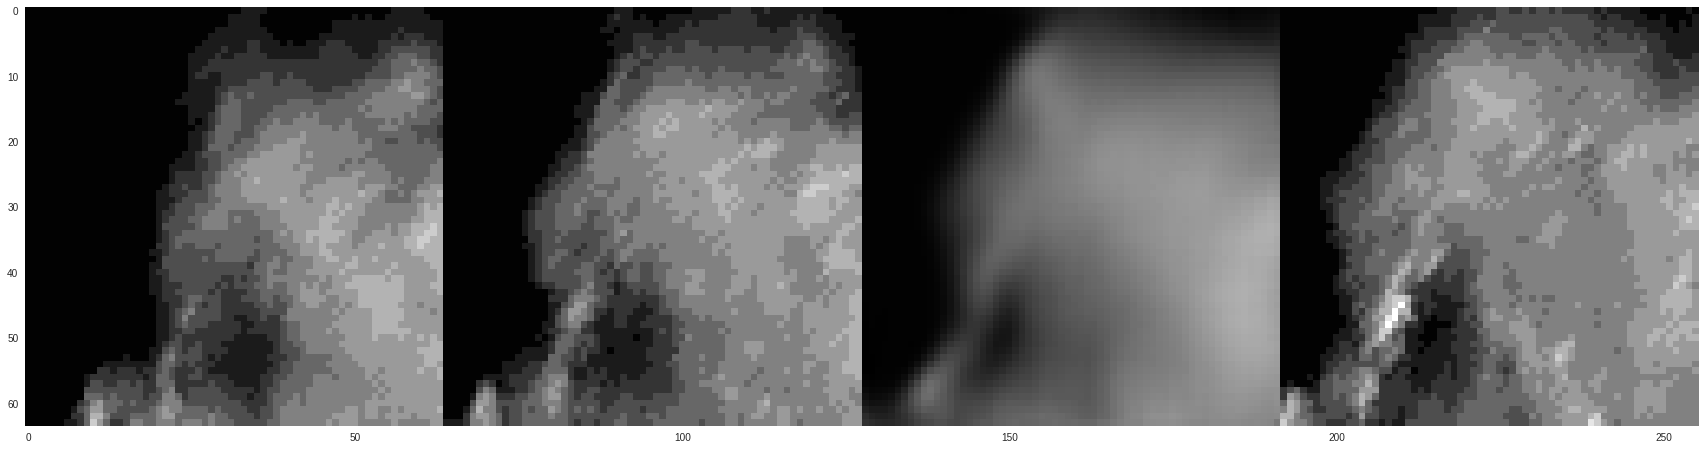

In [27]:
out = model( torch.tensor(X_test[0:10], dtype=torch.float).to(device) )
for i in range(10):
    mt.compare(i, X_test, y_test, out.cpu().detach().numpy(), folder="", channels_last=False)

In [28]:
print(training.history)

{'train': [0.03482173419151985], 'val': []}


In [0]:
torch.save(model.state_dict(), "weights")
!zip fig.zip *.png

  adding: 00.png (deflated 0%)
  adding: 01.png (stored 0%)
  adding: 02.png (deflated 0%)
  adding: 03.png (deflated 1%)
  adding: 04.png (stored 0%)
  adding: 05.png (deflated 3%)
  adding: 06.png (deflated 2%)
  adding: 07.png (stored 0%)
  adding: 08.png (stored 0%)
  adding: 09.png (deflated 3%)
